In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
pd.set_option('display.max_columns', 100)

C:\Users\jacks\AppData\Local\Temp\ipykernel_4028\2997209809.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


##
We have game results and odds data of Japanese soccer league (J1 League) from 2012 to 2024. We want to explore some interesting features of games in J1 League and use machine learning models to predict game results and expected goals from the data.

In [2]:
path = './data'
jpn = pd.read_csv(f'{path}/JPN.csv')
ftr_s = jpn['HG'].astype(str) + ':' + jpn['AG'].astype(str)
fttg = jpn['HG'] + jpn['AG']
jpn.insert(loc = 9,
          column = 'FTTG',
          value = fttg)
jpn.insert(loc = 10,
          column = 'FTR_S',
          value = ftr_s)
jpn.rename(columns={'Res': 'FTR'}, inplace=True)
teams = jpn['Home'].unique().tolist()
jpn

,Country,League,Season,Date,Time,Home,Away,HG,AG,FTTG,FTR_S,FTR,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,Japan,J1 League,2012,10/03/2012,05:00,Gamba Osaka,Vissel Kobe,2,3,5,2:3,A,1.94,3.56,4.34,1.94,4.00,5.50,1.71,3.62,4.55
1,Japan,J1 League,2012,10/03/2012,05:00,Sanfrecce Hiroshima,Urawa Reds,1,0,1,1:0,H,2.83,3.42,2.63,2.83,3.42,3.00,2.51,3.19,2.67
2,Japan,J1 League,2012,10/03/2012,05:00,Nagoya Grampus,Shimizu S-Pulse,1,0,1,1:0,H,1.68,4.09,5.37,1.75,4.09,5.50,1.65,3.62,4.88
3,Japan,J1 League,2012,10/03/2012,05:00,Sagan Tosu,Cerezo Osaka,0,0,0,0:0,D,3.31,3.48,2.29,3.31,3.48,2.29,3.01,3.23,2.24
4,Japan,J1 League,2012,10/03/2012,05:00,Hokkaido Consadole Sapporo,Iwata,0,0,0,0:0,D,3.28,3.47,2.31,3.28,3.65,2.50,2.86,3.20,2.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3936,Japan,J1 League,2024,16/06/2024,07:30,Avispa Fukuoka,Sagan Tosu,2,0,2,2:0,H,2.34,3.22,3.39,2.34,3.25,3.75,2.19,3.14,3.49
3937,Japan,J1 League,2024,16/06/2024,10:00,FC Tokyo,Iwata,1,1,2,1:1,D,2.00,3.61,3.87,2.03,3.63,4.17,1.95,3.46,3.81
3938,Japan,J1 League,2024,16/06/2024,10:00,Gamba Osaka,Kashiwa Reysol,2,1,3,2:1,H,2.25,3.33,3.44,2.25,3.35,3.45,2.20,3.25,3.32
3939,Japan,J1 League,2024,16/06/2024,10:00,Kashima Antlers,Albirex Niigata,1,1,2,1:1,D,1.89,3.56,4.42,1.92,3.61,4.43,1.87,3.48,4.16


##
From the histogram of goals per match, we can find that 1-3 goals are most common results and the chance of scoring 0-1 goal is much higher than England Premier League (EPL).

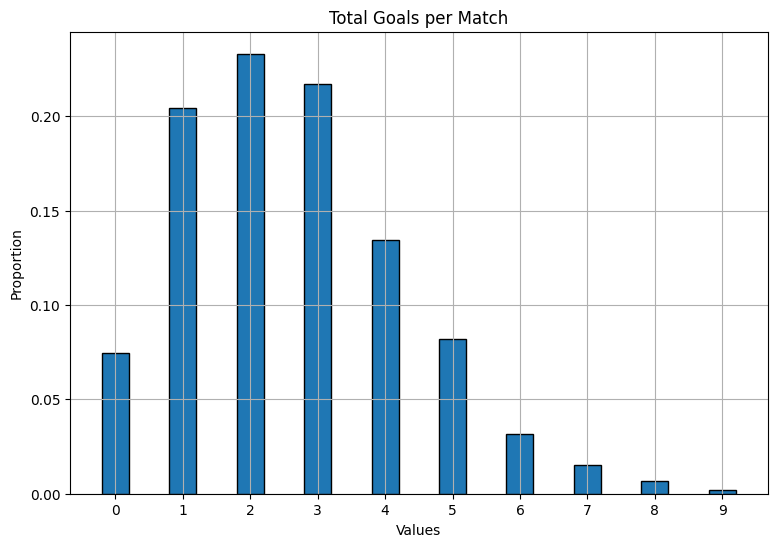

In [3]:
fttg = jpn['FTTG']
bin_edges = np.arange(-0.5, 10.5, 1)
plt.figure(figsize=(9, 6))
plt.hist(fttg, bins=bin_edges, edgecolor='black', rwidth=0.4, density=True)
plt.xlabel('Values')
plt.ylabel('Proportion')
plt.title('Total Goals per Match')
plt.grid(True)
plt.xticks(range(10))
plt.show()

##
Not surprisingly, 1:1, 0:1 and 1:0 are the most common game results. 

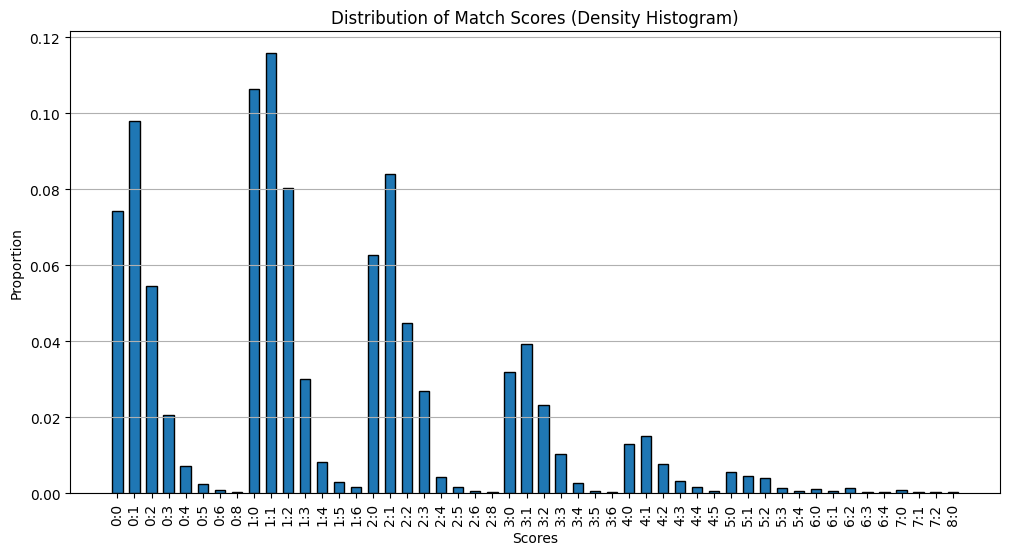

In [4]:
ftr_s = jpn['FTR_S']
bin_edges = np.arange(-1.5, 10.5, 1)

score_counts = ftr_s.value_counts(normalize=True).sort_index()

# Plot the density histogram as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(score_counts.index, score_counts.values, edgecolor='black', width=0.6)
plt.xlabel('Scores')
plt.ylabel('Proportion')
plt.title('Distribution of Match Scores (Density Histogram)')
plt.grid(axis='y')

# Display x-axis labels for all scores
plt.xticks(rotation=90)

plt.show()

##
After preprocessing the data, let's train a random forest model to predict expected goals (xG) and game results using max odds, average odds and close match betting odds from Pinnacle.

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
jpn_ml = jpn.copy()
encoder1 = LabelEncoder()
encoder2 = LabelEncoder()
encoder1.fit(jpn_ml['FTR'])
jpn_ml['FTR_encoded'] = encoder1.transform(jpn_ml['FTR'])
encoder2.fit(jpn_ml['Home'])
jpn_ml['home_team_encoded'] = encoder2.transform(jpn_ml['Home'])
jpn_ml['away_team_encoded'] = encoder2.transform(jpn_ml['Away'])
X = jpn_ml[['home_team_encoded', 'away_team_encoded', 'MaxH', 'MaxD', 'MaxA', 'PH', 'PD', 'PA', 'AvgH', 'AvgD', 'AvgA', 'Season']]
y_total_goals = jpn_ml['FTTG']
y_result_encoded = jpn_ml['FTR_encoded']

X_train, X_test, y_train_goals, y_test_goals = train_test_split(X, y_total_goals, test_size=0.2, random_state=42)
X_train, X_test, y_train_result, y_test_result = train_test_split(X, y_result_encoded, test_size=0.2, random_state=42)

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# Model for predicting total goals
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train_goals)

# Predict on test data
predictions_goals = regressor.predict(X_test)


# Model for predicting game result
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train_result)

# Predict on test data
predictions_result = classifier.predict(X_test)


In [7]:
from sklearn.metrics import mean_squared_error, accuracy_score

# Evaluation for total goals prediction
mse = mean_squared_error(y_test_goals, predictions_goals)
print("Mean Squared Error for Total Goals Prediction:", mse)

# Evaluation for game result prediction
accuracy = accuracy_score(y_test_result, predictions_result)
print("Accuracy for Game Result Prediction:", accuracy)


Mean Squared Error for Total Goals Prediction: 2.9642651457541187
Accuracy for Game Result Prediction: 0.4448669201520912


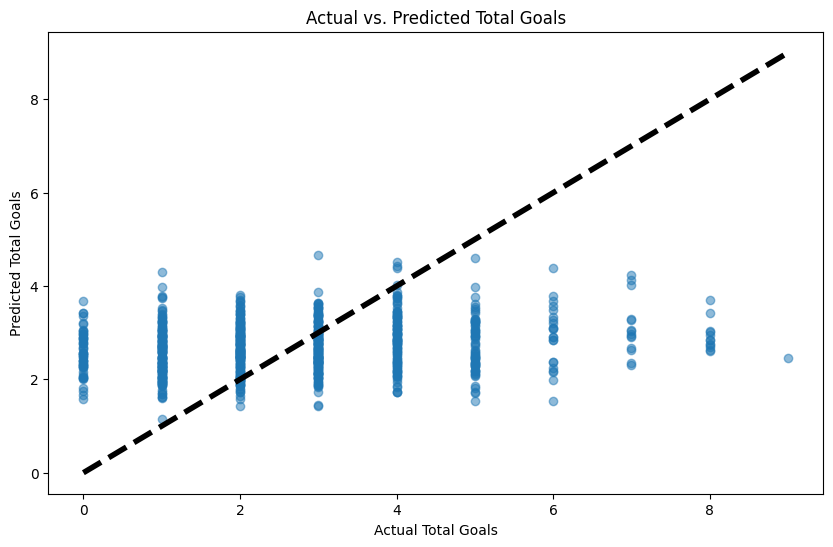

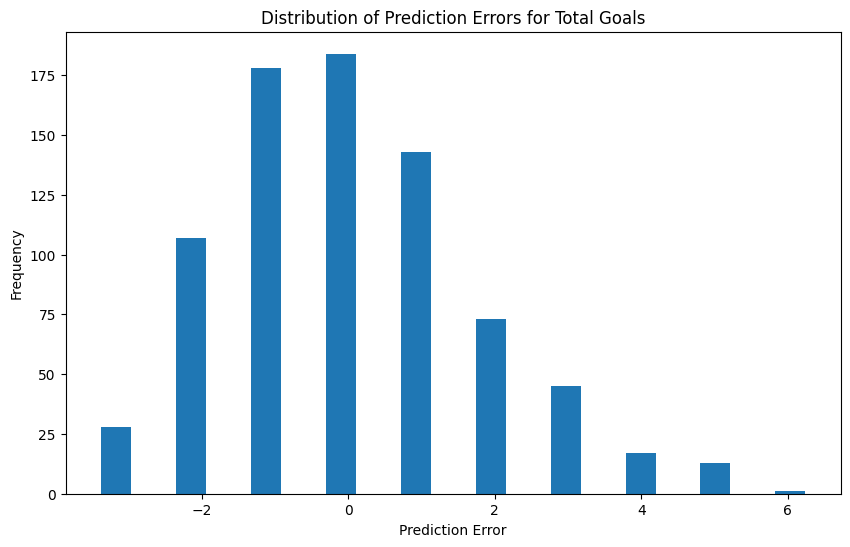

In [8]:
import matplotlib.pyplot as plt

# Scatter plot for actual vs. predicted total goals
plt.figure(figsize=(10, 6))
plt.scatter(y_test_goals, predictions_goals, alpha=0.5)
plt.title('Actual vs. Predicted Total Goals')
plt.xlabel('Actual Total Goals')
plt.ylabel('Predicted Total Goals')
plt.plot([y_test_goals.min(), y_test_goals.max()], [y_test_goals.min(), y_test_goals.max()], 'k--', lw=4)
plt.show()

# Histogram of prediction errors
errors = y_test_goals - predictions_goals
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=10, rwidth=0.4)
plt.title('Distribution of Prediction Errors for Total Goals')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()


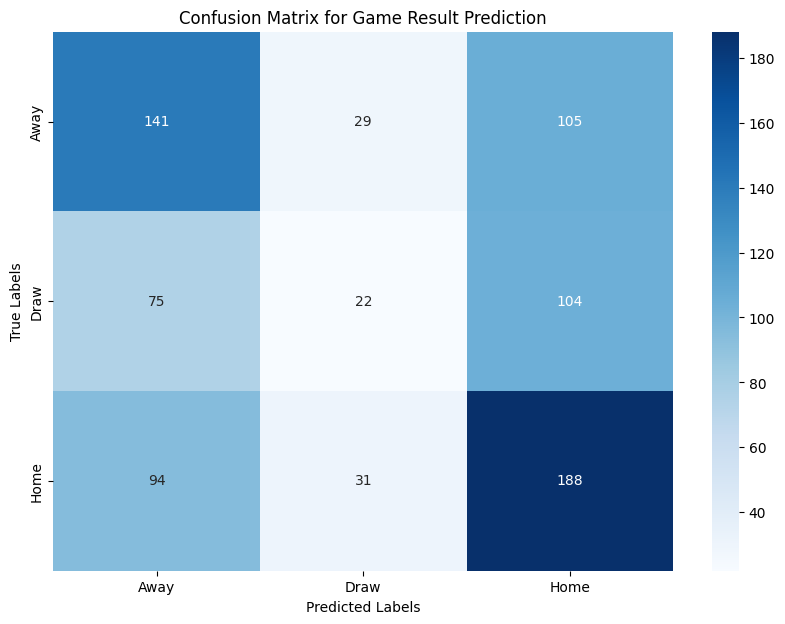

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_result, predictions_result)

# Define labels as per the encoded values: 0 = 'Away', 1 = 'Draw', 2 = 'Home'
labels = ['Away', 'Draw', 'Home']

# Plotting the confusion matrix with custom labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Game Result Prediction')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [10]:
from sklearn.metrics import classification_report, accuracy_score

# Assuming predictions_result and y_test_result are defined
# You've already calculated the confusion matrix
cm = confusion_matrix(y_test_result, predictions_result)

# Accuracy
accuracy = accuracy_score(y_test_result, predictions_result)
print("Accuracy:", accuracy)

# Precision, Recall, F1-score for each class
report = classification_report(y_test_result, predictions_result, target_names=['Away', 'Draw', 'Home'])
print(report)


Accuracy: 0.4448669201520912
              precision    recall  f1-score   support

        Away       0.45      0.51      0.48       275
        Draw       0.27      0.11      0.16       201
        Home       0.47      0.60      0.53       313

    accuracy                           0.44       789
   macro avg       0.40      0.41      0.39       789
weighted avg       0.41      0.44      0.42       789



##
Not surprisingly, the prediction result is not very good. Our odds data is still too little and we don't have the trends of data before match, which is very important. Many tied games are predicted to be either win or lose, mainly due to tied games are much less in our data. Anyways, we can use this model to predict game results for future games.

In [11]:
new_data = pd.DataFrame({
    'home_team': ['Albirex Niigata'],
    'away_team': ['Kawasaki Frontale'],
    'MaxH': [2.6],
    'MaxD': [3.86],
    'MaxA': [2.7],
    'PH': [2.55],
    'PD': [3.5],
    'PA': [2.6],
    'AvgH': [2.48],
    'AvgD': [3.5],
    'AvgA': [2.57],
    'Season': 2024
})

new_data['home_team_encoded'] = encoder2.transform(new_data['home_team'])
new_data['away_team_encoded'] = encoder2.transform(new_data['away_team'])

# Selecting features based on your model's requirements
features = ['home_team_encoded', 'away_team_encoded', 'MaxH', 'MaxD', 'MaxA', 'PH', 'PD', 'PA', 'AvgH', 'AvgD', 'AvgA', 'Season']
X_new = new_data[features]
predictions = classifier.predict(X_new)
result_labels = ['Away', 'Draw', 'Home']
predicted_results = [result_labels[pred] for pred in predictions]

print("Predicted Game Results:", predicted_results)

probabilities = classifier.predict_proba(X_new)
print("Prediction Probabilities:", probabilities)


Predicted Game Results: ['Away']
Prediction Probabilities: [[0.43 0.26 0.31]]


##
Naturally, a game between top ranked teams is very different from games at the final round. Therefore, we want to add some more information about **each game's importance** to both teams and the **teams' power** right before the game. Here I select five most recent seasons.

In [12]:
spi = pd.read_csv(f'{path}/spi_matches.csv')
spi = spi.loc[spi['league_id'] == 1947]
spi['team1'] = spi['team1'].replace('Urawa Red Diamonds', 'Urawa Reds')
spi['team2'] = spi['team2'].replace('Urawa Red Diamonds', 'Urawa Reds')
spi['team1'] = spi['team1'].replace('Jubilo Iwata', 'Iwata')
spi['team2'] = spi['team2'].replace('Jubilo Iwata', 'Iwata')
spi['team1'] = spi['team1'].replace('Consadole Sapporo', 'Hokkaido Consadole Sapporo')
spi['team2'] = spi['team2'].replace('Consadole Sapporo', 'Hokkaido Consadole Sapporo')
spi['team1'] = spi['team1'].replace('Nagoya Grampus Eight', 'Nagoya Grampus')
spi['team2'] = spi['team2'].replace('Nagoya Grampus Eight', 'Nagoya Grampus')
spi['team1'] = spi['team1'].replace('Matsumoto Yamaga FC', 'Yamaga')
spi['team2'] = spi['team2'].replace('Matsumoto Yamaga FC', 'Yamaga')
spi['team1'] = spi['team1'].replace('Tokushima Vortis', 'Tokushima')
spi['team2'] = spi['team2'].replace('Tokushima Vortis', 'Tokushima')
spi['team1'] = spi['team1'].replace('Kyoto Purple Sanga', 'Kyoto')
spi['team2'] = spi['team2'].replace('Kyoto Purple Sanga', 'Kyoto')
spi = spi[['season', 'date', 'team1', 'team2', 'spi1', 'spi2', 'prob1', 'prob2', 'probtie', 'importance1', 'importance2']]
spi['date'] = pd.to_datetime(spi['date'])
spi = spi.rename(columns={'season':'Season', 'date':'Date', 'team1':'Home', 'team2': 'Away'})

jpn_1823 = jpn.loc[jpn['Season'] >= 2018]
jpn_1823 = jpn_1823.loc[jpn['Season'] < 2024]
jpn_1823['Date'] = pd.to_datetime(jpn_1823['Date'])

jpn_merged = pd.merge(spi, jpn_1823, on=['Season', 'Date', 'Home', 'Away'], how='inner')
jpn_merged

C:\Users\jacks\AppData\Local\Temp\ipykernel_4028\2346574063.py:23: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  jpn_1823['Date'] = pd.to_datetime(jpn_1823['Date'])


,Season,Date,Home,Away,spi1,spi2,prob1,prob2,probtie,importance1,importance2,Country,League,Time,HG,AG,FTTG,FTR_S,FTR,PH,PD,PA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA
0,2018,2018-08-01,V-Varen Nagasaki,Hokkaido Consadole Sapporo,29.33,34.51,0.3454,0.3862,0.2685,NaN,NaN,Japan,J1 League,11:00,2,3,5,2:3,A,3.04,3.43,2.43,3.05,3.43,2.52,2.92,3.21,2.41
1,2018,2018-08-01,Urawa Reds,Kawasaki Frontale,51.88,55.30,0.3772,0.3647,0.2580,NaN,NaN,Japan,J1 League,11:00,2,0,2,2:0,H,3.22,3.51,2.29,3.22,3.60,2.49,2.97,3.41,2.29
2,2018,2018-08-01,Iwata,Gamba Osaka,38.54,29.84,0.5010,0.2297,0.2693,NaN,NaN,Japan,J1 League,11:00,1,1,2,1:1,D,2.14,3.53,3.53,2.25,3.53,3.54,2.14,3.36,3.30
3,2018,2018-08-01,Kashima Antlers,FC Tokyo,50.32,42.10,0.4799,0.2756,0.2445,NaN,NaN,Japan,J1 League,11:00,1,2,3,1:2,A,2.32,3.42,3.23,2.50,3.43,3.30,2.33,3.22,3.06
4,2018,2018-08-01,Cerezo Osaka,Vissel Kobe,44.12,45.37,0.3945,0.3591,0.2465,NaN,NaN,Japan,J1 League,11:00,1,1,2,1:1,D,1.93,3.80,3.98,2.05,3.81,4.05,1.92,3.58,3.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,2023,2023-11-25,Urawa Reds,Avispa Fukuoka,45.80,27.26,0.5930,0.1609,0.2461,NaN,NaN,Japan,J1 League,05:00,2,3,5,2:3,A,1.93,3.25,4.92,1.99,3.34,4.92,1.89,3.17,4.62
1039,2023,2023-11-25,Vissel Kobe,Nagoya Grampus,50.05,41.63,0.4760,0.2750,0.2490,NaN,NaN,Japan,J1 League,05:00,2,1,3,2:1,H,1.81,3.64,4.98,1.83,3.75,4.98,1.78,3.56,4.55
1040,2023,2023-11-25,Yokohama FC,Shonan Bellmare,17.62,25.33,0.3037,0.4444,0.2520,NaN,NaN,Japan,J1 League,05:00,0,1,1,0:1,A,2.65,3.34,2.85,2.65,3.46,2.87,2.51,3.31,2.76
1041,2023,2023-11-25,Cerezo Osaka,Kyoto,38.55,26.40,0.5390,0.2165,0.2445,NaN,NaN,Japan,J1 League,05:00,0,1,1,0:1,A,1.91,3.60,4.37,1.96,3.63,4.45,1.88,3.49,4.10


##
There are about 10% missing values in the importance column. Here we fill the nas with average value and do a normalization. After that, we can do the fit a random forest model again.

In [13]:
from sklearn.preprocessing import MinMaxScaler
jpn_merged['importance1'] = jpn_merged['importance1'].fillna(jpn_merged['importance1'].mean())
jpn_merged['importance2'] = jpn_merged['importance2'].fillna(jpn_merged['importance2'].mean())

scaler = MinMaxScaler()
jpn_merged['importance1'] = scaler.fit_transform(jpn_merged[['importance1']])
jpn_merged['importance2'] = scaler.fit_transform(jpn_merged[['importance2']])

In [14]:
jpn_spi_ml = jpn_merged.copy()
encoder1 = LabelEncoder()
encoder2 = LabelEncoder()
encoder1.fit(jpn_spi_ml['FTR'])
jpn_spi_ml['FTR_encoded'] = encoder1.transform(jpn_spi_ml['FTR'])
encoder2.fit(jpn_spi_ml['Home'])
jpn_spi_ml['home_team_encoded'] = encoder2.transform(jpn_spi_ml['Home'])
jpn_spi_ml['away_team_encoded'] = encoder2.transform(jpn_spi_ml['Away'])
X = jpn_spi_ml[['Season', 'spi1', 'spi2', 'importance1', 'importance2', 'home_team_encoded', 'away_team_encoded', 'PH', 'PD', 'PA']]
y_total_goals = jpn_spi_ml['FTTG']
y_result_encoded = jpn_spi_ml['FTR_encoded']

X_train, X_test, y_train_goals, y_test_goals = train_test_split(X, y_total_goals, test_size=0.2, random_state=42)
X_train, X_test, y_train_result, y_test_result = train_test_split(X, y_result_encoded, test_size=0.2, random_state=42)

In [15]:
# Model for predicting total goals
regressor = RandomForestRegressor(n_estimators=100, random_state=42)
regressor.fit(X_train, y_train_goals)

# Predict on test data
predictions_goals = regressor.predict(X_test)


# Model for predicting game result
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train_result)

# Predict on test data
predictions_result = classifier.predict(X_test)

In [16]:
# Evaluation for total goals prediction
mse = mean_squared_error(y_test_goals, predictions_goals)
print("Mean Squared Error for Total Goals Prediction:", mse)

# Evaluation for game result prediction
accuracy = accuracy_score(y_test_result, predictions_result)
print("Accuracy for Game Result Prediction:", accuracy)


Mean Squared Error for Total Goals Prediction: 3.3031937799043067
Accuracy for Game Result Prediction: 0.45933014354066987


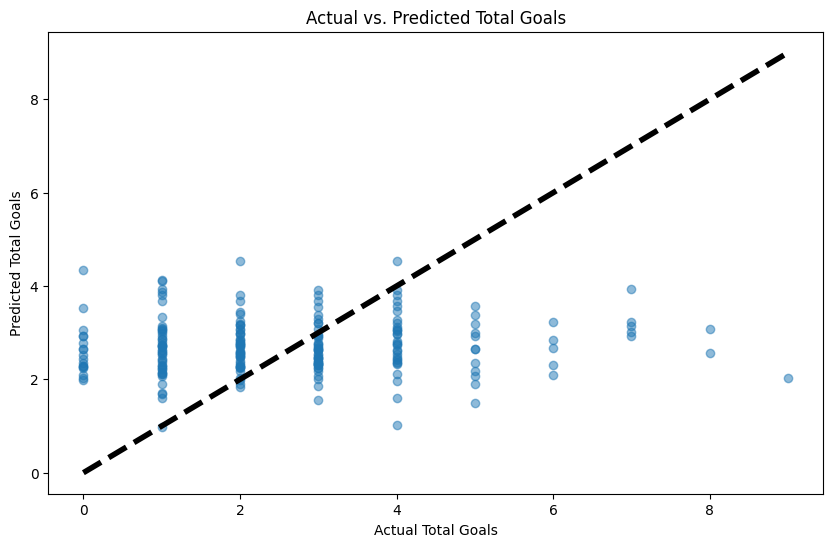

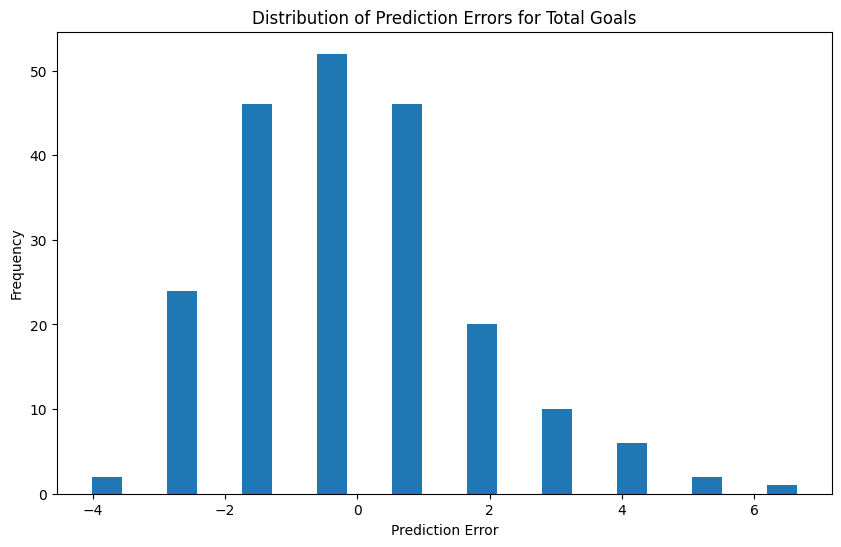

In [18]:
# Scatter plot for actual vs. predicted total goals
plt.figure(figsize=(10, 6))
plt.scatter(y_test_goals, predictions_goals, alpha=0.5)
plt.title('Actual vs. Predicted Total Goals')
plt.xlabel('Actual Total Goals')
plt.ylabel('Predicted Total Goals')
plt.plot([y_test_goals.min(), y_test_goals.max()], [y_test_goals.min(), y_test_goals.max()], 'k--', lw=4)
plt.show()

# Histogram of prediction errors
errors = y_test_goals - predictions_goals
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=10, rwidth=0.4)
plt.title('Distribution of Prediction Errors for Total Goals')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

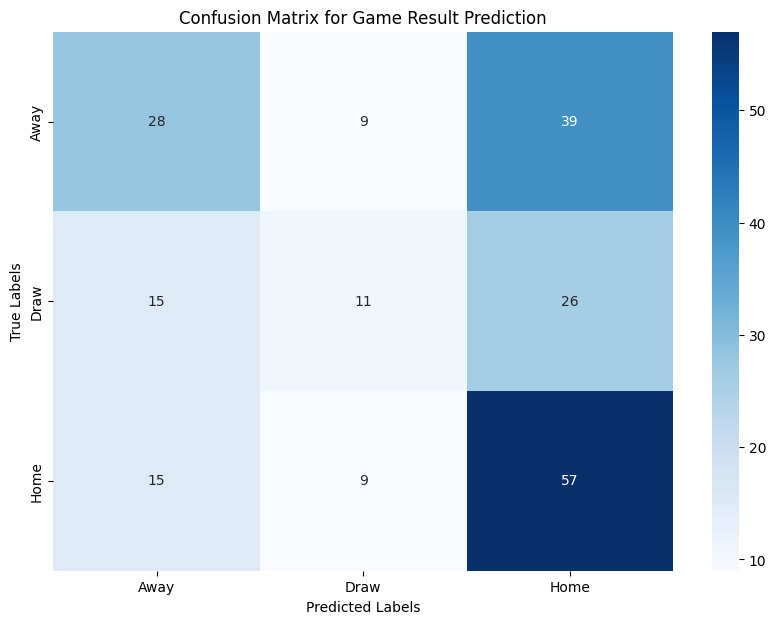

In [17]:
cm = confusion_matrix(y_test_result, predictions_result)

# Define labels as per the encoded values: 0 = 'Away', 1 = 'Draw', 2 = 'Home'
labels = ['Away', 'Draw', 'Home']

# Plotting the confusion matrix with custom labels
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Game Result Prediction')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()